In [1]:
%load_ext autoreload
%autoreload 2

# UCI dataset (abandoned)

From the accompanying Word doc:


>tra_X_te = test set input data, 36 locations by 48 features
>tra_X_tr = training set input data, 36 locations by 48 features

In [5]:
from scipy.io import loadmat

data = loadmat("../data/traffic/traffic_dataset.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'tra_X_tr', 'tra_X_te', 'tra_Y_tr', 'tra_Y_te', 'tra_adj_mat'])

In [16]:
# The whole thing is just in here:

print(len(data["tra_X_tr"][0]))
print(data["tra_X_tr"][0][0].shape)

1261
(36, 48)


In [18]:
data["tra_X_tr"][0][0].todense()

matrix([[0.09248015, 0.09668379, 0.07006072, ..., 0.        , 0.        ,
         0.        ],
        [0.09715086, 0.10228865, 0.08173751, ..., 0.        , 0.        ,
         0.        ],
        [0.11536665, 0.11069594, 0.10555815, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.06772536, 0.08173751, 0.06118636, ..., 0.        , 0.        ,
         1.        ],
        [0.09388136, 0.11069594, 0.08827651, ..., 0.        , 0.        ,
         1.        ],
        [0.08313872, 0.06679122, 0.06725829, ..., 0.        , 1.        ,
         0.        ]])

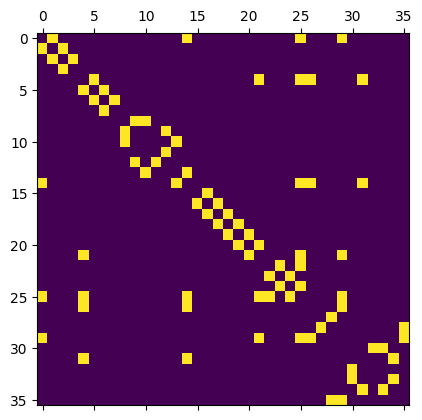

In [17]:
import matplotlib.pyplot as plt

plt.matshow(data["tra_adj_mat"])

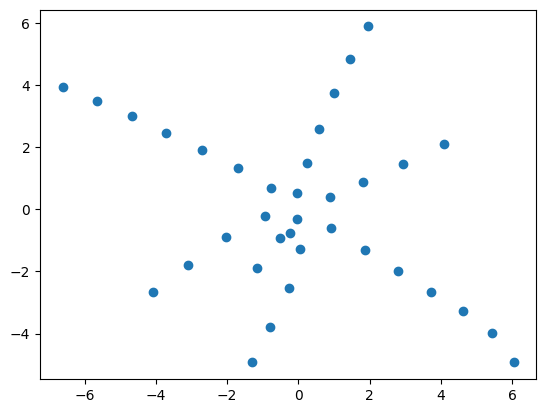

In [20]:
# Adjacency matrix -> nx graph -> pairwise dists -> MDS coords in R2

import networkx as nx
import numpy as np
from sklearn.manifold import MDS

G = nx.from_numpy_array(data["tra_adj_mat"])
dists = nx.floyd_warshall_numpy(G)
dists = np.array([[dists[i][j] for j in range(len(dists))] for i in range(len(dists))])
dists

mds = MDS(n_components=2, dissimilarity="precomputed")
coords = mds.fit_transform(dists)
coords

plt.scatter(coords[:, 0], coords[:, 1])

In [72]:
np.stack(
    [x[:, 10:17].todense().flatten() for x in data["tra_X_tr"][0]],
).sum(axis=1)

matrix([[72.],
        [72.],
        [72.],
        ...,
        [36.],
        [36.],
        [36.]])

In [52]:
# Make dataset


def make_dataset(X, Y, coords):
    X_out, y_out = [], []
    for x, y in zip(X, Y):
        # x is a 36x48 sparse matrix
        for row, coord in zip(x.todense(), coords):
            row = np.array(row).flatten()
            print(row.shape)
            embedding = [coord[0], coord[1]]

            # Get week day
            print(row[10:17])
            weekday = np.argmax(row[10:17])
            assert sum(row[10:17]) == 1
            weekday_angle = weekday / 7 * 2 * np.pi
            embedding += [np.cos(weekday_angle), np.sin(weekday_angle)]

            # Get hour
            hour = np.argmax(row[17:41])
            # assert sum(row[17:41]) == 1
            hour_angle = hour / 24 * 2 * np.pi
            embedding += [np.cos(hour_angle), np.sin(hour_angle)]

            X_out.append(embedding)
            y_out.append(y)

    return np.array(X_out), np.array(y_out)


X_train, y_train = make_dataset(data["tra_X_tr"][0], data["tra_Y_tr"][0], coords)

(48,)
[1. 0. 0. 0. 0. 1. 0.]


AssertionError: 

In [101]:
# First, let's extract the weekday and hour features from the first example to infer their structure.
sample_matrix = data["tra_X_tr"][0][0]  # Taking the first sparse matrix
weekday_features = sample_matrix[:, 10:17].toarray()  # Assuming weekdays are stored after the historical traffic volume
hour_features = sample_matrix[:, 17:41].toarray()  # Assuming hours are stored right after weekdays

# Now, we can go through all matrices and extract these two sets of features
weekdays = []
hours = []

bad = []
for i in range(data["tra_X_tr"].shape[1]):
    current_matrix = data["tra_X_tr"][0][i]
    weekday = current_matrix[:, 10:17].toarray()
    hour = current_matrix[:, 17:41].toarray()
    if (weekday.sum(axis=1) == 1).all() and (hour.sum(axis=1) == 1).all(): 
        weekdays.append(weekday)  
        hours.append(hour)
    else:
        bad.append(i)

# Convert the lists to numpy arrays
weekdays_array = np.vstack(weekdays)
hours_array = np.vstack(hours)

# We can now construct the (1261 x 2) matrix
day_hour_indices = np.column_stack((weekdays_array.argmax(axis=1), hours_array.argmax(axis=1)))
day_hour_indices

ValueError: need at least one array to concatenate

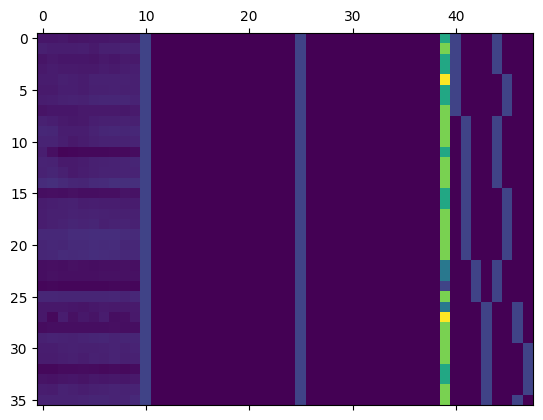

In [99]:
plt.matshow( data["tra_X_tr"][0][1000].todense())

# Kaggle dataset

In [1]:
import pandas as pd

data = "../data/traffic/traffic.csv"
df = pd.read_csv(data)
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [15]:
# Turn datetime to floats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import numpy as np


# X = df["DateTime"].astype(int)
# Convert DateTime to number
X = pd.to_datetime(df["DateTime"]).astype(int)
y = df["Vehicles"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train.values.reshape(-1, 1), np.log(y_train))

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(np.log(y_test), dt.predict(X_test.values.reshape(-1, 1))))

0.804981962649683

In [9]:
# Turn datetime into day of year, day of week, hour, and minute
df["datetime"] = pd.to_datetime(df["DateTime"])
df["day_of_week"] = df["datetime"].dt.dayofweek
df["hour"] = df["datetime"].dt.hour
df["day_of_year"] = df["datetime"].dt.dayofyear
df["minute"] = df["datetime"].dt.minute

In [ ]:
df["J"]

,DateTime,Junction,Vehicles,ID,datetime,day_of_week,hour,day_of_year,minute
0,1446336000000000000,1,15,20151101001,2015-11-01 00:00:00,6,0,305,0
1,1446339600000000000,1,13,20151101011,2015-11-01 01:00:00,6,1,305,0
2,1446343200000000000,1,10,20151101021,2015-11-01 02:00:00,6,2,305,0
3,1446346800000000000,1,7,20151101031,2015-11-01 03:00:00,6,3,305,0
4,1446350400000000000,1,9,20151101041,2015-11-01 04:00:00,6,4,305,0
...,...,...,...,...,...,...,...,...,...
48115,1498849200000000000,4,11,20170630194,2017-06-30 19:00:00,4,19,181,0
48116,1498852800000000000,4,30,20170630204,2017-06-30 20:00:00,4,20,181,0
48117,1498856400000000000,4,16,20170630214,2017-06-30 21:00:00,4,21,181,0
48118,1498860000000000000,4,22,20170630224,2017-06-30 22:00:00,4,22,181,0


In [16]:
X = df[["day_of_week", "hour", "day_of_year", "minute"]]
y = df["Vehicles"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, np.log(y_train))

np.sqrt(mean_squared_error(np.log(y_test), dt.predict(X_test)))

0.7842458567277176

In [108]:
# Maxima are helpful for understanding how to normalize the data

df.max()

DateTime       2017-06-30 23:00:00
Junction                         4
Vehicles                       180
ID                     20170630234
datetime       2017-06-30 23:00:00
day_of_week                      6
hour                            23
day_of_year                    366
minute                           0
dtype: object

In [10]:
angle = lambda x, n : x / n * 2 * np.pi

X, y = [], []
for i, row in df.iterrows():
    _, jct, vehicles, _, _, day, hr, doy, minute = row
    X.append([
        jct,
        np.cos(angle(doy, 365)),
        np.sin(angle(doy, 365)),
        np.cos(angle(day, 7)),
        np.sin(angle(day, 7)),
        np.cos(angle(hr, 24)),
        np.sin(angle(hr, 24)),
        np.cos(angle(minute, 60)),
        np.sin(angle(minute, 60)),
    ])
    y.append(vehicles)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(48120, 9) (48120,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dt.fit(X_train, np.log(y_train))

np.sqrt(mean_squared_error(np.log(y_test), dt.predict(X_test)))

0.5110039427301307

In [126]:
import torch
import embedders

N_SAMPLES = 1_000
N_TRIALS = 100
MAX_DEPTH = 3
N_FEATURES = "d_choose_2"

pm = embedders.manifolds.ProductManifold(signature=[(0, 1), (1, 1), (1, 1), (1, 1), (1, 1)])

results = []
for trial in range(N_TRIALS):
    idx = np.random.choice(len(X), N_SAMPLES, replace=False)
    res = embedders.benchmarks.benchmark(
        X[idx], np.log(y)[idx], task="regression", seed=trial, pm=pm, score="rmse", max_depth=MAX_DEPTH, n_features=N_FEATURES
    )
    res["trial"] = trial
    results.append(res)

results = pd.DataFrame(results)
results

,sklearn_dt,sklearn_rf,product_dt,product_rf,tangent_dt,tangent_rf,knn,trial
0,0.499881,0.471579,0.510808,0.501063,0.491782,0.487915,0.470003,0
1,0.540501,0.528995,0.554908,0.592320,0.555719,0.554799,0.530374,1
2,0.549478,0.526699,0.555476,0.548153,0.534987,0.514790,0.529992,2
3,0.551682,0.528056,0.577761,0.616434,0.550924,0.539020,0.496902,3
4,0.527916,0.509313,0.568128,0.565096,0.528305,0.518158,0.504739,4
...,...,...,...,...,...,...,...,...
95,0.525503,0.501887,0.544129,0.596911,0.531989,0.513832,0.516901,95
96,0.514873,0.498000,0.507997,0.608682,0.537936,0.511809,0.506575,96
97,0.516987,0.496662,0.504692,0.555068,0.537637,0.515582,0.475806,97
98,0.551450,0.547163,0.579263,0.574400,0.571732,0.557793,0.546955,98


In [128]:
results.to_csv("../data/results/traffic_results.tsv", index=False, sep="\t")

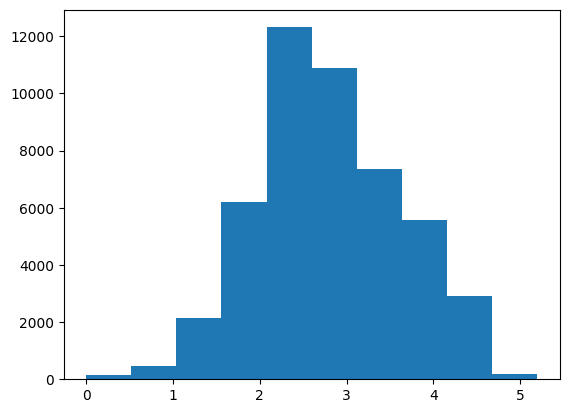

In [125]:
plt.hist(np.log(y))
plt.show()